# Begin visualisations

In [1]:
from pathlib import Path
import pandas as pd
import sqlite3
import networkx as nx
#import matplotlib.pyplot as plt
from ipycytoscape import CytoscapeWidget
from sqlite3 import OperationalError
from contextlib import suppress
import ipywidgets as widgets
from pprint import pprint
import py4cytoscape as p4c
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tqdm.notebook import tqdm



In [2]:
working = Path('..')
working

PosixPath('..')

In [3]:
!pwd

/Users/tarah/Library/Mobile Documents/com~apple~CloudDocs/ONGOING-Oxford/OxfordTree/oxford_uni/dh-trace/notebooks


In [4]:
!ls $working

LICENSE                    load_hapaxes.py
Project History.pdf        load_jaccard.py
README.md                  load_ngram_intersects.py
__pycache__                load_ngrams.py
arch                       load_relationships.py
authors.txt                make_3d_plot.py
auto_author_prediction.py  make_auto_scatterplot.py
begin.sh                   make_confusion.py
cleaning_splitting_scripts make_dash.py
cytoscape-layouts          make_histogram.py
database_ops.py            make_jumbo_dash.py
dh-trace-venv              make_lines.py
diagrams.ipynb             notebooks
do_svm.py                  poetry.lock
do_viz.sh                  predict_ops.py
explore                    projects
hapaxes_1tM.py             pyproject.toml
init_db.py                 requirements.txt
jan24                      show_previous_averages.py
load_alignments.py         util.py
load_authors_and_texts.py  utils
load_hapax_intersects.py


In [5]:
things = working.glob('*')

In [6]:
for thing in things:
    print(thing)

../make_dash.py
../database_ops.py
../diagrams.ipynb
../.DS_Store
../LICENSE
../requirements.txt
../cleaning_splitting_scripts
../make_lines.py
../util.py
../auto_author_prediction.py
../make_confusion.py
../projects
../pyproject.toml
../predict_ops.py
../load_jaccard.py
../do_viz.sh
../utils
../cytoscape-layouts
../__pycache__
../load_hapaxes.py
../Project History.pdf
../jan24
../explore
../README.md
../load_ngram_intersects.py
../load_hapax_intersects.py
../load_ngrams.py
../.gitignore
../arch
../load_alignments.py
../make_jumbo_dash.py
../begin.sh
../load_authors_and_texts.py
../hapaxes_1tM.py
../make_auto_scatterplot.py
../show_previous_averages.py
../make_3d_plot.py
../poetry.lock
../.git
../.vscode
../load_relationships.py
../authors.txt
../dh-trace-venv
../make_histogram.py
../notebooks
../do_svm.py
../.current_project
../init_db.py


In [7]:
project_name = 'sm-test'
project_path = working / 'projects' / project_name

In [8]:
project_path

PosixPath('../projects/sm-test')

In [9]:
db_path = project_path / 'db' / f'{project_name}.db'
svm_db_path = project_path / 'db' / 'svm.db'
db_path
svm_db_path

PosixPath('../projects/sm-test/db/svm.db')

In [10]:
db_path.exists()

True

In [11]:
# Define the EDGES_QUERY template with placeholders for weight_id and threshold
EDGES_QUERY_TEMPLATE = """
WITH RankedResults AS (
    SELECT 
        calculation.pair_id,
        round(calculation.comp_score, 3) as comp_score,
        calculation.threshold,
        weight.weight_id,
        weight.hap_weight,
        weight.al_weight,
        weight.svm_weight,
        combined_jaccard.hap_jac_dis,
        combined_jaccard.hap_jac_sim,
        combined_jaccard.al_jac_dis,
        combined_jaccard.al_jac_sim,
        text_pair.text_a AS a_text_id,
        text_pair.text_b AS b_text_id,
        text_a.source_filename AS a_text_filename,
        text_b.source_filename AS b_text_filename,
        text_a.chapter_num AS a_chap_num,
        text_b.chapter_num AS b_chap_num,
        dir_a.id AS a_work_dir_id,
        dir_b.id AS b_work_dir_id,
        dir_a.dir AS a_work,
        dir_b.dir AS b_work,
        text_a.author_id AS a_author_id,
        text_b.author_id AS b_author_id,
        text_a.short_name_for_svm AS a_short,
        text_b.short_name_for_svm AS b_short,
        calculation.same_author,
        author_a.author_name AS a_author,
        author_b.author_name AS b_author,
        ROW_NUMBER() OVER (PARTITION BY weight.weight_id, calculation.threshold ORDER BY calculation.pair_id) as row_num,
        RANDOM() as rand_val
    FROM calculations AS calculation
    JOIN text_pairs AS text_pair ON text_pair.id = calculation.pair_id
    JOIN weights AS weight ON weight.weight_id = calculation.weight_id
    JOIN all_texts AS text_a ON text_a.text_id = text_pair.text_a
    JOIN all_texts AS text_b ON text_b.text_id = text_pair.text_b
    JOIN dirs AS dir_a ON dir_a.id = text_a.dir
    JOIN dirs AS dir_b ON dir_b.id = text_b.dir
    JOIN authors AS author_a ON author_a.id = text_a.author_id
    JOIN authors AS author_b ON author_b.id = text_b.author_id
    JOIN combined_jaccard ON combined_jaccard.pair_id = calculation.pair_id
    WHERE weight.weight_id = {weight_id}
      AND calculation.threshold = {threshold}
      AND dir_a.id <> dir_b.id
    ORDER BY rand_val
)
SELECT *
FROM RankedResults
ORDER BY weight_id, pair_id
"""

In [12]:
EDGES_QUERY_TEMPLATE

'\nWITH RankedResults AS (\n    SELECT \n        calculation.pair_id,\n        round(calculation.comp_score, 3) as comp_score,\n        calculation.threshold,\n        weight.weight_id,\n        weight.hap_weight,\n        weight.al_weight,\n        weight.svm_weight,\n        combined_jaccard.hap_jac_dis,\n        combined_jaccard.hap_jac_sim,\n        combined_jaccard.al_jac_dis,\n        combined_jaccard.al_jac_sim,\n        text_pair.text_a AS a_text_id,\n        text_pair.text_b AS b_text_id,\n        text_a.source_filename AS a_text_filename,\n        text_b.source_filename AS b_text_filename,\n        text_a.chapter_num AS a_chap_num,\n        text_b.chapter_num AS b_chap_num,\n        dir_a.id AS a_work_dir_id,\n        dir_b.id AS b_work_dir_id,\n        dir_a.dir AS a_work,\n        dir_b.dir AS b_work,\n        text_a.author_id AS a_author_id,\n        text_b.author_id AS b_author_id,\n        text_a.short_name_for_svm AS a_short,\n        text_b.short_name_for_svm AS b_shor

In [13]:
con = sqlite3.connect(db_path)

In [14]:
# Cleanup any edges that might already exist.
con.execute("DROP TABLE IF EXISTS edges")
con.commit()
con.execute("DROP VIEW IF EXISTS edges")
con.commit()

# Fetch unique weight_ids from the database
weight_ids_query = "SELECT DISTINCT weight_id FROM weights"
weight_ids_df = pd.read_sql(weight_ids_query, con)
weight_ids = weight_ids_df['weight_id'].tolist()

# Fetch unique thresholds from the database
thresholds_query = "SELECT DISTINCT threshold FROM calculations"
thresholds_df = pd.read_sql(thresholds_query, con)
thresholds = thresholds_df['threshold'].tolist()

total_iterations = len(weight_ids) * len(thresholds)

i = 0
con.execute("BEGIN TRANSACTION")
with tqdm(total=total_iterations, desc="Processing") as pbar:
    for weight_id in weight_ids:
        for threshold in thresholds:
            # Format the query with the current weight_id and threshold
            formatted_query = EDGES_QUERY_TEMPLATE.format(weight_id=weight_id, threshold=threshold)
            
            # Print the formatted query to check for syntax issues
            print(formatted_query)
            
            if i < 1:
                # Create the initial view
                create_view_query = f"CREATE TEMP TABLE edges AS {formatted_query}"
                try:
                    con.execute(create_view_query)
                    con.commit()
                except sqlite3.OperationalError as e:
                    print(f"Error creating initial view: {e}")
                i += 1
            else:
                append_view_query = f"INSERT INTO edges SELECT * FROM ({formatted_query})"
                try:
                    con.execute(append_view_query)
                except sqlite3.OperationalError as e:
                    print(f"Error appending to view: {e}")

            pbar.update(1)

con.commit()


Processing:   0%|          | 0/216 [00:00<?, ?it/s]


WITH RankedResults AS (
    SELECT 
        calculation.pair_id,
        round(calculation.comp_score, 3) as comp_score,
        calculation.threshold,
        weight.weight_id,
        weight.hap_weight,
        weight.al_weight,
        weight.svm_weight,
        combined_jaccard.hap_jac_dis,
        combined_jaccard.hap_jac_sim,
        combined_jaccard.al_jac_dis,
        combined_jaccard.al_jac_sim,
        text_pair.text_a AS a_text_id,
        text_pair.text_b AS b_text_id,
        text_a.source_filename AS a_text_filename,
        text_b.source_filename AS b_text_filename,
        text_a.chapter_num AS a_chap_num,
        text_b.chapter_num AS b_chap_num,
        dir_a.id AS a_work_dir_id,
        dir_b.id AS b_work_dir_id,
        dir_a.dir AS a_work,
        dir_b.dir AS b_work,
        text_a.author_id AS a_author_id,
        text_b.author_id AS b_author_id,
        text_a.short_name_for_svm AS a_short,
        text_b.short_name_for_svm AS b_short,
        calculation.same_

In [15]:
# Initialize an empty list to store query results
all_results = []

# Calculate the total number of iterations
total_iterations = len(weight_ids) * len(thresholds)

# Use tqdm to create a progress bar
with tqdm(total=total_iterations, desc="Query Execution") as pbar:
    for weight_id in weight_ids:
        for threshold in thresholds:
            # Format the query with the current weight_id and threshold
            query = EDGES_QUERY_TEMPLATE.format(weight_id=weight_id, threshold=threshold)
            
            # Execute the query and fetch results
            results = pd.read_sql(query, con)
            
            # Add results to the list
            all_results.append(results)
            
            # Update the progress bar
            pbar.update(1)

# Combine all results into a single DataFrame
edges_df = pd.concat(all_results, ignore_index=True)
print(len(edges_df))

Query Execution:   0%|          | 0/216 [00:00<?, ?it/s]

681696


In [16]:
svm_con = sqlite3.connect(svm_db_path)

def get_svm_score(a_short, a_chap_num, b_short):
    query = f"""
    SELECT {b_short} AS svm_score
    FROM chapter_assessments
    WHERE novel = ?
    AND number = ?
    """
    
    result = pd.read_sql(query, svm_con, params=(a_short, a_chap_num))
    
    if not result.empty:
        return result['svm_score'].iloc[0]
    return None

# Initialize tqdm to monitor progress
tqdm.pandas(desc="Calculating SVM Scores")

# Apply the function to each row in edges_df
edges_df['svm_score'] = edges_df.progress_apply(lambda row: get_svm_score(row['a_short'], row['a_chap_num'], row['b_short']), axis=1)

# Close the connection to svm.db
svm_con.close()

Calculating SVM Scores:   0%|          | 0/681696 [00:00<?, ?it/s]

In [17]:
#edges_df = pd.read_sql(df_query, con)
print(f"{len(edges_df):,}")
print(edges_df.sample(n=100, random_state=42))
columns_list = edges_df.columns.tolist()
print(columns_list)
print(len(edges_df))

681,696
        pair_id  comp_score  threshold  weight_id  hap_weight  al_weight  \
410521     7630       0.781       0.70         16       0.450      0.275   
499317    21001       0.668       0.90         19       0.300      0.300   
110926    13947       0.906       0.75          4       0.175      0.650   
644755    50433       0.948       0.80         25       0.300      0.350   
172065   112787       0.944       0.90          6       0.600      0.200   
...         ...         ...        ...        ...         ...        ...   
445357    11467       0.626       0.85         17       0.275      0.275   
84351    159939       0.772       0.70          3       0.175      0.175   
299638   193921       0.770       0.90         11       0.550      0.225   
225254    74816       0.923       0.95          8       0.200      0.200   
472774   171000       0.917       0.85         18       0.300      0.400   

        svm_weight  hap_jac_dis  hap_jac_sim  al_jac_dis  ...  a_author_id  \
4

In [18]:
# NOTE: This is just here so we can see all the columns. Delete when sure it works.
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
display(edges_df)
print(len(edges_df))

,pair_id,comp_score,threshold,weight_id,hap_weight,al_weight,svm_weight,hap_jac_dis,hap_jac_sim,al_jac_dis,al_jac_sim,a_text_id,b_text_id,a_text_filename,b_text_filename,a_chap_num,b_chap_num,a_work_dir_id,b_work_dir_id,a_work,b_work,a_author_id,b_author_id,a_short,b_short,same_author,a_author,b_author,row_num,rand_val,svm_score
0,54,0.516,0.60,0,0.15,0.15,0.7,0.948298,0.051702,0.998171,0.001829,567,135,1840-ENG18400—Trollope-chapter_1,1846-ENG18460—Reynolds-chapter_117,1,117,9,1,1840-ENG18400—Trollope,1846-ENG18460—Reynolds,9,1,ENG18400—Trollope,ENG18460—Reynolds,No,Trollope,Reynolds,1,-3840320679677316127,0.893267
1,60,0.514,0.60,0,0.15,0.15,0.7,0.934469,0.065531,0.997997,0.002003,567,9,1840-ENG18400—Trollope-chapter_1,1846-ENG18460—Reynolds-chapter_122,1,122,9,1,1840-ENG18400—Trollope,1846-ENG18460—Reynolds,9,1,ENG18400—Trollope,ENG18460—Reynolds,No,Trollope,Reynolds,2,-3242125631371812100,0.893267
2,111,0.515,0.60,0,0.15,0.15,0.7,0.944510,0.055490,0.998374,0.001626,567,243,1840-ENG18400—Trollope-chapter_1,1846-ENG18460—Reynolds-chapter_169,1,169,9,1,1840-ENG18400—Trollope,1846-ENG18460—Reynolds,9,1,ENG18400—Trollope,ENG18460—Reynolds,No,Trollope,Reynolds,3,-1020856545636209817,0.893267
3,138,0.516,0.60,0,0.15,0.15,0.7,0.942105,0.057895,0.998650,0.001350,567,240,1840-ENG18400—Trollope-chapter_1,1846-ENG18460—Reynolds-chapter_193,1,193,9,1,1840-ENG18400—Trollope,1846-ENG18460—Reynolds,9,1,ENG18400—Trollope,ENG18460—Reynolds,No,Trollope,Reynolds,4,-1900761378679912717,0.893267
4,353,0.662,0.60,0,0.15,0.15,0.7,0.937110,0.062890,0.998567,0.001433,567,629,1840-ENG18400—Trollope-chapter_1,1848-ENG18481—Dickens-chapter_44,1,44,9,10,1840-ENG18400—Trollope,1848-ENG18481—Dickens,9,10,ENG18400—Trollope,ENG18481—Dickens,False Positive,Trollope,Dickens,5,3558955641964293878,0.668953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681691,211830,0.880,0.95,26,0.35,0.35,0.3,0.948811,0.051189,0.998880,0.001120,350,406,1863-ENG18632—Reade-chapter_55,1880-ENG18800—Disraeli-chapter_30,55,30,3,6,1863-ENG18632—Reade,1880-ENG18800—Disraeli,3,6,ENG18632—Reade,ENG18800—Disraeli,No,Reade,Disraeli,3152,8189845688372471843,0.668185
681692,212132,0.879,0.95,26,0.35,0.35,0.3,0.950986,0.049014,0.998404,0.001596,327,483,1863-ENG18632—Reade-chapter_7,1880-ENG18800—Disraeli-chapter_21,7,21,3,6,1863-ENG18632—Reade,1880-ENG18800—Disraeli,3,6,ENG18632—Reade,ENG18800—Disraeli,No,Reade,Disraeli,3153,-6505340718026543523,0.771777
681693,212175,0.880,0.95,26,0.35,0.35,0.3,0.952886,0.047114,0.998606,0.001394,327,457,1863-ENG18632—Reade-chapter_7,1880-ENG18800—Disraeli-chapter_60,7,60,3,6,1863-ENG18632—Reade,1880-ENG18800—Disraeli,3,6,ENG18632—Reade,ENG18800—Disraeli,No,Reade,Disraeli,3154,-6730076854339797629,0.771777
681694,212207,0.884,0.95,26,0.35,0.35,0.3,0.967287,0.032713,0.997922,0.002078,327,419,1863-ENG18632—Reade-chapter_7,1880-ENG18800—Disraeli-chapter_9,7,9,3,6,1863-ENG18632—Reade,1880-ENG18800—Disraeli,3,6,ENG18632—Reade,ENG18800—Disraeli,No,Reade,Disraeli,3155,-7035581627375824077,0.771777


681696


In [19]:
# SOLVED A way to choose whether to exclude a piece of a work from connecting to itself (e.g. Trollope 1840 ch 10, ibid ch 20) (solved in SQL)

#A way to visibly toggle the thresholds to fine-grainedly shade edges and possibly connect them closer

#A way to only display desired authors all the way down to one
#A way to visibly toggle the weights
#A way to light up nodes above a certain threshold even if lower thresholds are displayed
#use pandas to group by work so individual book can be displayed on the graph below. 
#check that all four results in same_author are showing up (yes, no, false positive, false negative)

#edges_df = edges_df.sample(1000)
print(len(edges_df))
min_comp_score = edges_df['comp_score'].min() 
max_comp_score = edges_df['comp_score'].max() 
print(min_comp_score, max_comp_score)

# Filter the DataFrame for rows where 'same_author' equals 'yes'
print(edges_df[edges_df['same_author'] == 'Yes'].head(10))
# Filter the DataFrame for rows where 'same_author' equals 'no'
print(edges_df[edges_df['same_author'] == 'No'].head(10))
# Filter the DataFrame for rows where 'same_author' equals 'false_positive'
print(edges_df[edges_df['same_author'] == 'False Positive'].head(10))
# Filter the DataFrame for rows where 'same_author' equals 'false_negative'
print(edges_df[edges_df['same_author'] == 'False Negative'].head(10))


681696
0.289 0.993
Empty DataFrame
Columns: [pair_id, comp_score, threshold, weight_id, hap_weight, al_weight, svm_weight, hap_jac_dis, hap_jac_sim, al_jac_dis, al_jac_sim, a_text_id, b_text_id, a_text_filename, b_text_filename, a_chap_num, b_chap_num, a_work_dir_id, b_work_dir_id, a_work, b_work, a_author_id, b_author_id, a_short, b_short, same_author, a_author, b_author, row_num, rand_val, svm_score]
Index: []
    pair_id  comp_score  threshold  weight_id  hap_weight  al_weight  \
0        54       0.516        0.6          0        0.15       0.15   
1        60       0.514        0.6          0        0.15       0.15   
2       111       0.515        0.6          0        0.15       0.15   
3       138       0.516        0.6          0        0.15       0.15   
6       423       0.439        0.6          0        0.15       0.15   
8       878       0.515        0.6          0        0.15       0.15   
9       899       0.588        0.6          0        0.15       0.15   
13      

Now, let's add the logistic regression logic. 

In [20]:
# Load your data into a DataFrame (assuming it's already done)
# edges_df = pd.read_sql(df_query, con)

# Select relevant features and target
features = ['hap_jac_sim', 'al_jac_sim', 'svm_score']
X = edges_df[features]
y = edges_df['same_author']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

# Coefficients of the model
print("Model coefficients (weights for the features):")
for feature, coef in zip(features, model.coef_[0]):
    print(f"{feature}: {coef}")

/Users/tarah/Library/Mobile Documents/com~apple~CloudDocs/ONGOING-Oxford/OxfordTree/oxford_uni/dh-trace/jan24/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tarah/Library/Mobile Documents/com~apple~CloudDocs/ONGOING-Oxford/OxfordTree/oxford_uni/dh-trace/jan24/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.7243508874871645
Confusion Matrix:
[[98758     0]
 [37582     0]]
Classification Report:
                precision    recall  f1-score   support

False Positive       0.72      1.00      0.84     98758
            No       0.00      0.00      0.00     37582

      accuracy                           0.72    136340
     macro avg       0.36      0.50      0.42    136340
  weighted avg       0.52      0.72      0.61    136340

Model coefficients (weights for the features):
hap_jac_sim: 24.21249246538464
al_jac_sim: -1.313888459986813
svm_score: -0.1411763001075486


/Users/tarah/Library/Mobile Documents/com~apple~CloudDocs/ONGOING-Oxford/OxfordTree/oxford_uni/dh-trace/jan24/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [21]:
G = nx.from_pandas_edgelist(
    edges_df,
    source = 'a_text_filename',
    target = 'b_text_filename',
    edge_attr = ['comp_score'],
    create_using = nx.DiGraph)
                            
                            

In [22]:
print(edges_df.sample(n=10))

        pair_id  comp_score  threshold  weight_id  hap_weight  al_weight  \
322426    15637       0.867       0.90         12       0.250      0.500   
282042    72947       0.959       0.65         11       0.550      0.225   
357635    60651       0.938       0.65         14       0.500      0.250   
54992     89404       0.945       0.65          2       0.700      0.150   
387386   162367       0.894       0.70         15       0.275      0.450   
80722    127937       0.849       0.65          3       0.175      0.175   
541717   144672       0.943       0.75         21       0.325      0.325   
300641    35752       0.946       0.95         11       0.550      0.225   
648739   123045       0.946       0.85         25       0.300      0.350   
659380   190982       0.713       0.60         26       0.350      0.350   

        svm_weight  hap_jac_dis  hap_jac_sim  al_jac_dis  al_jac_sim  \
322426       0.250     0.929573     0.070427    0.999581    0.000419   
282042       0.225 

In [23]:
G

In [24]:
TEXT_FONT_SIZE = 8

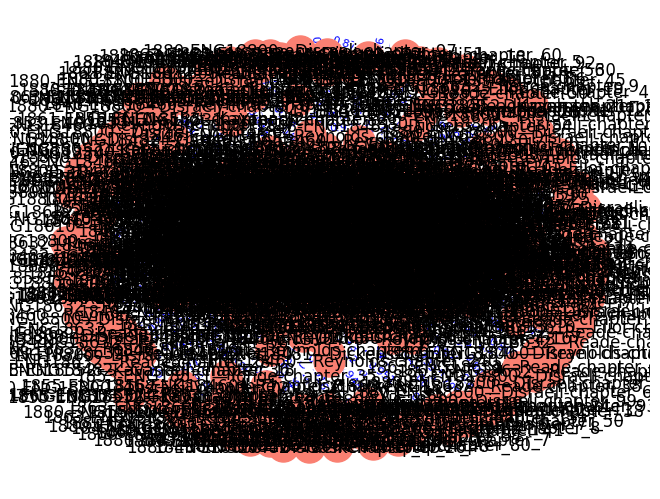

In [25]:
# Position nodes using Fruchterman-Reingold force-directed algorithm
pos = nx.spring_layout(G)

 # Draw nodes with labels
nx.draw(G, width=1, node_size=500, node_color='salmon', with_labels=True)
# Draw edges with arrows and labels
edge_labels = nx.get_edge_attributes(G, 'comp_score')
_ = nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='blue', font_size=TEXT_FONT_SIZE)


In [26]:
C = CytoscapeWidget()
#C.set_layout(name='cola')
C.set_layout(name='dagre', rankDir='LR', spacingFactor=3)
C.graph.add_graph_from_networkx(G, directed=True)


In [27]:
#this is so we can programmatically edit and choose variables for the graph

def build_style(color_threshold):
    return [
        {
             'selector': 'node',
             'style': {
                 'background-color': 'salmon',
                 'font-family': 'helvetica',
                 'font-size': f"{TEXT_FONT_SIZE}px",
                 'label': 'data(id)'
             }
        },
        {
             'selector': 'edge',
             'style': {
                 'line-color': 'black',
                 'font-family': 'helvetica',
                 'font-size': f"{TEXT_FONT_SIZE}px",
                 'color': 'blue',
                 'label': 'data(comp_score)',
                'width': f"mapData(comp_score, {min_comp_score}, {max_comp_score}, 1, 10)"
                 #'width': '10px',
             }
        },
        {
            "selector": "edge.directed",
            "style": {
                "curve-style": "bezier",
                "target-arrow-shape": "triangle",
                "target-arrow-color": "black",
            }
        }, 
        {
            "selector": f"edge[comp_score>{color_threshold}]",
            "style": {
                "line-color": "red",
            }
        },
    ]
style = build_style(0.92)
pprint(style)
C.set_style(style)

[{'selector': 'node',
  'style': {'background-color': 'salmon',
            'font-family': 'helvetica',
            'font-size': '8px',
            'label': 'data(id)'}},
 {'selector': 'edge',
  'style': {'color': 'blue',
            'font-family': 'helvetica',
            'font-size': '8px',
            'label': 'data(comp_score)',
            'line-color': 'black',
            'width': 'mapData(comp_score, 0.289, 0.993, 1, 10)'}},
 {'selector': 'edge.directed',
  'style': {'curve-style': 'bezier',
            'target-arrow-color': 'black',
            'target-arrow-shape': 'triangle'}},
 {'selector': 'edge[comp_score>0.92]', 'style': {'line-color': 'red'}}]


In [28]:
#make slider

caption = widgets.Label(value='The slider value is in its initial position.')

slider = widgets.IntSlider(
    value=90,
    min=90,
    max=100,
    step=1,
    description='Test:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
def handle_slider_change(change):
    color_threshold = change.new / 100
    caption.value = f"The slider value is: {color_threshold}"
    style = build_style(color_threshold=color_threshold)
    C.set_style(style)
    
slider.observe(handle_slider_change, names='value')
display(caption, slider)

Label(value='The slider value is in its initial position.')

IntSlider(value=90, continuous_update=False, description='Test:', min=90)

In [29]:
C

CytoscapeWidget(cytoscape_layout={'name': 'dagre', 'rankDir': 'LR', 'spacingFactor': 3}, cytoscape_style=[{'se…

 # MOVE OVER TO CYTOSCAPE APP FOR STRETCHY THINGS

 ## todo

 1. annotate edges in dataset
 2. regenerate all data
 3. deal with SVMs
 4. document and lock sequence alignment version
 5. fully remove and document removal of n-grams
 7. display more easy to see
 8. full dataset
 9. moving to dissertation; initial check against tarah's dataset
 10. do full relevant close re-reading
 11. 

In [30]:
p4c.cytoscape_ping()

You are connected to Cytoscape!


'You are connected to Cytoscape!'

In [31]:
p4c.cytoscape_version_info()

{'apiVersion': 'v1',
 'cytoscapeVersion': '3.10.2',
 'automationAPIVersion': '1.9.0',
 'py4cytoscapeVersion': '1.9.0'}

In [32]:
p4c.create_network_from_networkx(G)


Applying default style...
Applying preferred layout


65100